<a href="https://colab.research.google.com/github/JonathanCheng123/AmazonLSTMNet/blob/main/Team_E_AmazonReview_LSTMNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TEAM E - AMAZON REVIEWS

In this project you work on Amazon food review from customers, and try to predict whether a review is positive or negative. 

**Dataset:**

The dataset contains more than 500K reviews with scores given by customers, number of upvotes & total votes to those comments. The dataset has ‘Score’ label which is given by customers to each product. Scores range from 1-5. 

For doing a binary classification, you need to get rid of score ‘3’ reviews (neutral) and separate the remaining reviews into binary class (1 = positive, 0 = negative)

**Size:** 394,375 instances

**Classes:** 2 (Positive = 1 , Negative = 0 )

**Class skewness:**

instance belonging to Negative class: 61,625

instances belonging to Positive class: 332,750

**Note: Reviews are skewed towards positive.**


In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
%matplotlib inline 
import matplotlib.pyplot as plt
import gc
import string
import nltk
from nltk.stem import WordNetLemmatizer 
nltk.download('wordnet')
import keras
import gensim

from nltk.corpus import stopwords
nltk.download('stopwords')
stop = set(stopwords.words('english'))

from tensorflow.keras import layers
from sklearn.feature_extraction.text import TfidfVectorizer

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


Using TensorFlow backend.


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
text = pd.read_csv("/content/drive/My Drive/Cosmos/train.csv",delimiter='\t', usecols=[10])
scored = pd.read_csv("/content/drive/My Drive/Cosmos/train.csv",delimiter='\t', usecols=[7])
test = pd.read_csv("/content/drive/My Drive/Cosmos/train.csv",delimiter='\t', usecols=[10])
testscored = pd.read_csv("/content/drive/My Drive/Cosmos/train.csv",delimiter='\t', usecols=[7])

In [ ]:
lemmatizer = WordNetLemmatizer()
def preprocess(s):
  return lemmatizer.lemmatize(s)

In [ ]:
cutoff=120000
scorecutoff=50000
features=15000
vocab_size = 10000
max_length = 16952 

In [ ]:
reviews=text.Text.tolist()
testreviews = test.Text.tolist()
score = scored.to_numpy().reshape(len(scored),1,1)
testscore = testscored.to_numpy().reshape(len(testscored),1,1)

In [ ]:
score1 = []
reviews1=[]
c=0
for i in range(len(reviews)):
  if(score[i]==0):
    if(c<30000):
      c += 1
      score1.append(score[i])
      reviews1.append(reviews[i])
c=0    
for i in range(len(reviews)):
  if(score[i]==1):
    if(c<90000):
      c += 1
      score1.append(score[i])
      reviews1.append(reviews[i])
score = score1
reviews = reviews1

In [ ]:
vectorizer = TfidfVectorizer(stop_words=stop, analyzer = 'word',max_features=features, dtype=np.float32, preprocessor=preprocess)
vectorizer.fit(text.Text)

score = np.array(score)
testscore = testscored.to_numpy()[0:scorecutoff].reshape(scorecutoff,1,1)

X_trainv = np.array([vectorizer.transform([a]).astype('float32').toarray() for a in reviews])
X_testv = np.array([vectorizer.transform([a]).astype('float32').toarray() for a in test.Text.tolist()[:scorecutoff]])

/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['doe', 'ha', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [ ]:
X_train = np.squeeze(X_trainv)
X_train=X_train.reshape((len(X_train),1,features))
X_test = np.squeeze(X_testv).reshape(scorecutoff, 1, features)

In [ ]:
model = tf.keras.Sequential()
model.add(layers.LSTM(50, input_shape=(1,15000),return_sequences = True, recurrent_regularizer=tf.keras.regularizers.l2(0.005), kernel_initializer = 'glorot_normal', activation = 'relu'))
# model.add(layers.LSTM(64, return_sequences = True, kernel_initializer = 'glorot_normal', activation = 'relu', recurrent_regularizer=tf.keras.regularizers.l2(0.01)))
model.add(layers.TimeDistributed(layers.Dense(16,activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.005))))
model.add(layers.TimeDistributed(layers.Dense(32,activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1,activation='sigmoid'))

model.compile(loss='binary_crossentropy',metrics=['accuracy'],optimizer=tf.train.AdamOptimizer(0.0002))

W0802 20:28:52.568425 140042651363200 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1288: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0802 20:28:52.932219 140042651363200 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [ ]:
model.summary()
print ("Inputs: {}".format(model.input_shape))
print ("Outputs: {}".format(model.output_shape))
print ("Actual input: {}".format(X_train.shape))
print ("Actual output: {}".format(score.shape))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 1, 50)             3010200   
_________________________________________________________________
time_distributed (TimeDistri (None, 1, 16)             816       
_________________________________________________________________
time_distributed_1 (TimeDist (None, 1, 32)             544       
_________________________________________________________________
dropout (Dropout)            (None, 1, 32)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 1, 1)              33        
Total params: 3,011,593
Trainable params: 3,011,593
Non-trainable params: 0
_________________________________________________________________
Inputs: (None, 1, 15000)
Outputs: (None, 1, 1)
Actual input: (120000, 1, 15000)
Actual output: (120000, 1, 1)


In [ ]:
a=model.fit(X_train, score, epochs=15,batch_size=256, validation_data=[X_test, testscore])

Train on 120000 samples, validate on 50000 samples
Epoch 1/15
120000/120000 [==============================] - 13s 104us/sample - loss: 0.9445 - acc: 0.7489 - val_loss: 0.6100 - val_acc: 0.8367
Epoch 2/15
120000/120000 [==============================] - 11s 95us/sample - loss: 0.5293 - acc: 0.8213 - val_loss: 0.3456 - val_acc: 0.9290
Epoch 3/15
120000/120000 [==============================] - 11s 94us/sample - loss: 0.3567 - acc: 0.9050 - val_loss: 0.2585 - val_acc: 0.9381
Epoch 4/15
120000/120000 [==============================] - 11s 93us/sample - loss: 0.2947 - acc: 0.9172 - val_loss: 0.2245 - val_acc: 0.9431
Epoch 5/15
120000/120000 [==============================] - 12s 96us/sample - loss: 0.2649 - acc: 0.9259 - val_loss: 0.2051 - val_acc: 0.9468
Epoch 6/15
120000/120000 [==============================] - 11s 94us/sample - loss: 0.2464 - acc: 0.9304 - val_loss: 0.1935 - val_acc: 0.9490
Epoch 7/15
120000/120000 [==============================] - 11s 96us/sample - loss: 0.2345 - acc

In [ ]:
model.evaluate(X_test,testscore,batch_size=32)

50000/50000 [==============================] - 9s 172us/sample - loss: 0.1446 - acc: 0.9612


[0.14457092921972275, 0.96116]

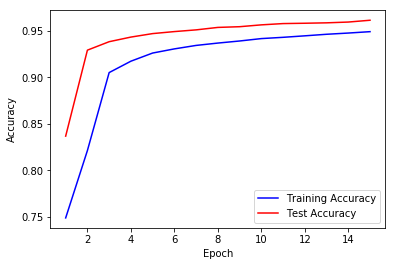

In [ ]:
val_acc = a.history['val_acc']
train_acc = a.history['acc']
epoch_count = range(1, len(val_acc) + 1)
plt.plot(epoch_count, train_acc, 'b')
plt.plot(epoch_count, val_acc, 'r')
plt.legend(['Training Accuracy', 'Test Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show();

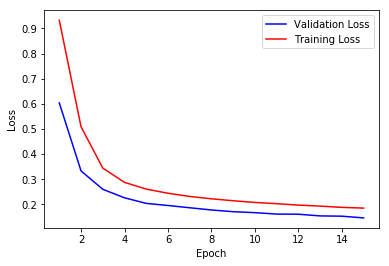

In [ ]:
training_loss = a.history['loss']
val_loss = a.history['val_loss']
epoch_count = range(1, len(val_loss) + 1)
plt.plot(epoch_count, val_loss, 'b')
plt.plot(epoch_count, training_loss, 'r')
plt.legend(['Validation Loss', 'Training Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();

In [ ]:
def process(a):
  v=vectorizer.transform([a]).toarray()
  v=v.reshape(1,1,features)
  return v

string = input('Enter a review: ')
a = model.predict(process(string),batch_size=1,verbose = 0)
print(a)
if(a[0]>0.5):
  print("Positive review")
else:
  print("Negative review")

Enter a review: the candles were exquisite
[[[0.85550344]]]
Positive review


In [ ]:
model.save('drive/My Drive/model')

In [ ]:
from tensorflow.keras.models import load_model
model = load_model('drive/My Drive/model')

In [ ]:
print(text[0])
print(textarray[0])